In [1]:
import jax.numpy as jnp
import jax
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import lib

In [3]:
"""this takes ~30 min to run on a laptop"""

n_patterns_list = [50, 100, 200, 300, 350, 400, 425, 450, 500]
# n_patterns_list = [200]
noise_list = [0, 0.005, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1]
n_success_list = np.zeros((len(n_patterns_list), len(noise_list)))
for n_patterns_idx, n_patterns in enumerate(n_patterns_list):
    print("n_patterns_per_cluster: ", n_patterns, end="    ")
    tree_struct_list = (2, 5, n_patterns) # ultrametric tree structure
    tree_diff_ratio = (0.5, 0.2, 0.05) # the coding level of the ancestors, 1st-generation descendants, and 2-nd generation descendants
    # tree_struct_list = (1, 60, )
    # tree_diff_ratio = (0.5, 0.05, )
    n_input_neurons = 500
    key = jax.random.PRNGKey(23)
    ultrametric_tree = lib.UltraMetricTree(key, n_input_neurons, tree_struct_list, tree_diff_ratio)
    ultrametric_tree.construct_tree()
    tree_network = lib.TreeNetwork(n_input_neurons, tree_struct_list=tree_struct_list[:-1], tree_decay1_list=(0.99, 0.99),    tree_decay2_list=(0.999, 0.99), decay3=1.)
    all_descendents = jnp.array(ultrametric_tree.descendents)[0]
    all_descendents_flattened = np.array(all_descendents.reshape((-1, n_input_neurons)))
    all_descendents_flattened = np.random.permutation(all_descendents_flattened)
    n_descendents = all_descendents_flattened.shape[0]

    """weights initialization"""
    tree_network.initialize(all_descendents, n_iterations=1)

    """online nsmf training"""
    np.random.seed(2308)
    n_epochs = 10000
    for i in range(n_epochs):
        sample_idx = np.random.randint(n_descendents)
        tree_network.update_weights(all_descendents_flattened[sample_idx], trainHopfieldQ=False)

    """offline Hopfield training, no nsmf training"""
    tree_network.reset_hopfield_weights()
    for i in range(n_descendents):
        tree_network.update_weights(all_descendents_flattened[i], trainHopfieldQ=True, trainSNMFQ=False)
    print("training finish!")

    """test"""
    tolerance=5
    for noise_idx, noise in enumerate(noise_list):
        noise_array = np.random.choice([0, 1], (n_descendents, n_input_neurons), p=[1-noise, noise])
        noised_descendents = np.bitwise_xor(all_descendents_flattened, noise_array)

        n_failure=0
        for i in range(n_descendents):
            x0 = all_descendents_flattened[i]
            x = noised_descendents[i]
            retrieved_x = tree_network.retrieve(x, n_hopfield_iterations=10, countingQ=True)
            if np.sum(np.abs(retrieved_x-x0)) > tolerance:
                n_failure += 1

        n_success_list[n_patterns_idx, noise_idx] = n_patterns - n_failure/n_descendents*n_patterns

n_patterns_per_cluster:  50    training finish!
n_patterns_per_cluster:  100    training finish!
n_patterns_per_cluster:  200    training finish!
n_patterns_per_cluster:  300    training finish!
n_patterns_per_cluster:  350    training finish!
n_patterns_per_cluster:  400    training finish!
n_patterns_per_cluster:  425    training finish!
n_patterns_per_cluster:  450    training finish!
n_patterns_per_cluster:  500    training finish!


Text(0.5, 1.0, 'tree structure = (2, 5, n_patterns_per_cluster) \n coding level = (0.5, 0.2, 0.05) \n each pattern has 500 neurons, tolerance = 5')

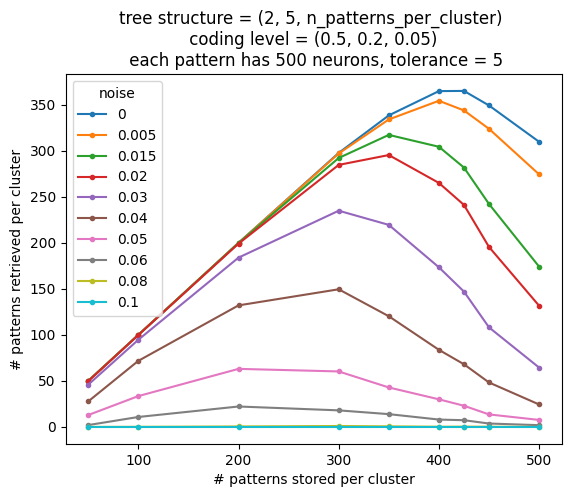

In [4]:
for noise_idx in range(len(noise_list)):
    plt.plot(n_patterns_list, n_success_list[:, noise_idx], label=f"{noise_list[noise_idx]}", marker=".")
plt.legend(title="noise")
plt.xlabel("# patterns stored per cluster")
plt.ylabel("# patterns retrieved per cluster")
plt.title("tree structure = (2, 5, n_patterns_per_cluster) \n coding level = (0.5, 0.2, 0.05) \n each pattern has 500 neurons, tolerance = 5")